## Notebook 3: Optimization of building design parameters using Pyomo

**1. Prepare Problem**

In [1]:
# a) Load libraries
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from skopt.space import Real, Integer

from SALib.analyze import sobol
from SALib.sample.sobol import sample as sobol_sample
from SALib.analyze import sobol as sobol_analyze

from pyomo.environ import *
from pyomo.opt import SolverFactory

from sklearn.ensemble import RandomForestRegressor

import pickle

import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# b) Load dataset
# Load and view each file in the dataset
data = pd.read_csv('EPB_data.csv', header=0)
print(data.shape)
print(data.head(10))
print(data.dtypes)

(768, 10)
   Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   
5                  0.90         563.5      318.5     122.50             7.0   
6                  0.90         563.5      318.5     122.50             7.0   
7                  0.90         563.5      318.5     122.50             7.0   
8                  0.86         588.0      294.0     147.00             7.0   
9                  0.86         588.0      294.0     147.00             7.0   

   Orientation  Glazing Area  Glazing Area Distribution  Heating Load  \
0            2           0.0                   

One of the approach in optimizing building energy efficiency is to minimize total energy consumption, which is the sum of heating and cooling.

In [3]:
# Calculate total energy consumption by summing up heating and cooling loads
data['Energy_Consumption'] = data[['Heating Load', 'Cooling Load']].sum(axis=1)
print(data.shape)

# Define features and label
X = data.drop(columns=['Heating Load', 'Cooling Load', 'Energy_Consumption'], axis = 1)
# Rename columns to remove whitespace
X = X.rename(columns=lambda X: X.strip().replace(' ', '_'))
y = data['Energy_Consumption']
print(X.shape, y.shape)
print(X.head(5))

(768, 11)
(768, 8) (768,)
   Relative_Compactness  Surface_Area  Wall_Area  Roof_Area  Overall_Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   

   Orientation  Glazing_Area  Glazing_Area_Distribution  
0            2           0.0                          0  
1            3           0.0                          0  
2            4           0.0                          0  
3            5           0.0                          0  
4            2           0.0                          0  


**2. Dataset summary**

In [4]:
# a) Descriptive statistics
set_option("display.precision", 3)
print(data.describe())

       Relative Compactness  Surface Area  Wall Area  Roof Area  \
count               768.000       768.000    768.000    768.000   
mean                  0.764       671.708    318.500    176.604   
std                   0.106        88.086     43.626     45.166   
min                   0.620       514.500    245.000    110.250   
25%                   0.682       606.375    294.000    140.875   
50%                   0.750       673.750    318.500    183.750   
75%                   0.830       741.125    343.000    220.500   
max                   0.980       808.500    416.500    220.500   

       Overall Height  Orientation  Glazing Area  Glazing Area Distribution  \
count         768.000      768.000       768.000                    768.000   
mean            5.250        3.500         0.234                      2.812   
std             1.751        1.119         0.133                      1.551   
min             3.500        2.000         0.000                      0.000   
2

In [5]:
# checking categorical features
cat_features = data.select_dtypes(include='O').keys()
# display variabels
cat_features

Index([], dtype='object')

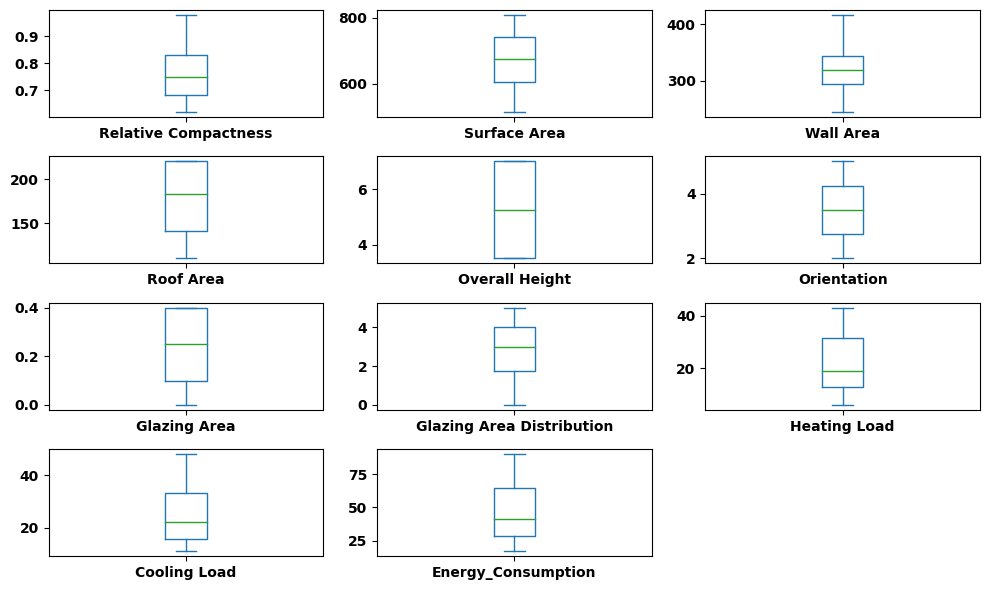

In [6]:
# b) Data visualizations
# Box and Whisker Plots of a few features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,3), sharex=False, sharey=False)
plt.show()

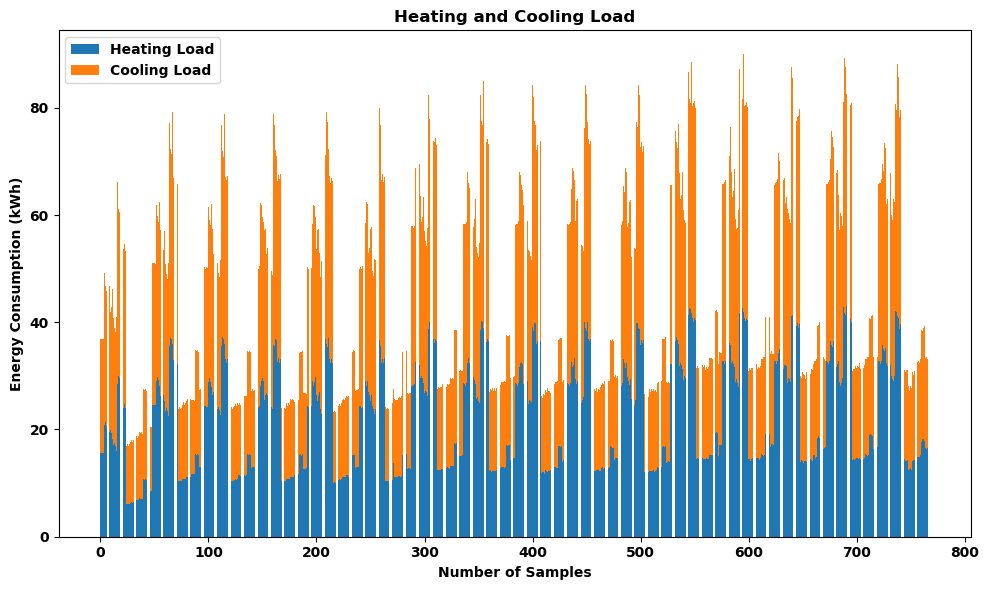

In [7]:
# create the stack bar chart of Heating and Cooling Load
fig, ax = plt.subplots()
ax.bar(np.arange(len(data['Heating Load'])), data['Heating Load'], label='Heating Load')
ax.bar(np.arange(len(data['Cooling Load'])), data['Cooling Load'], bottom=data['Heating Load'], label='Cooling Load')

# add labels, title and legend
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_title('Heating and Cooling Load')
ax.legend()

# show the plot
plt.show()

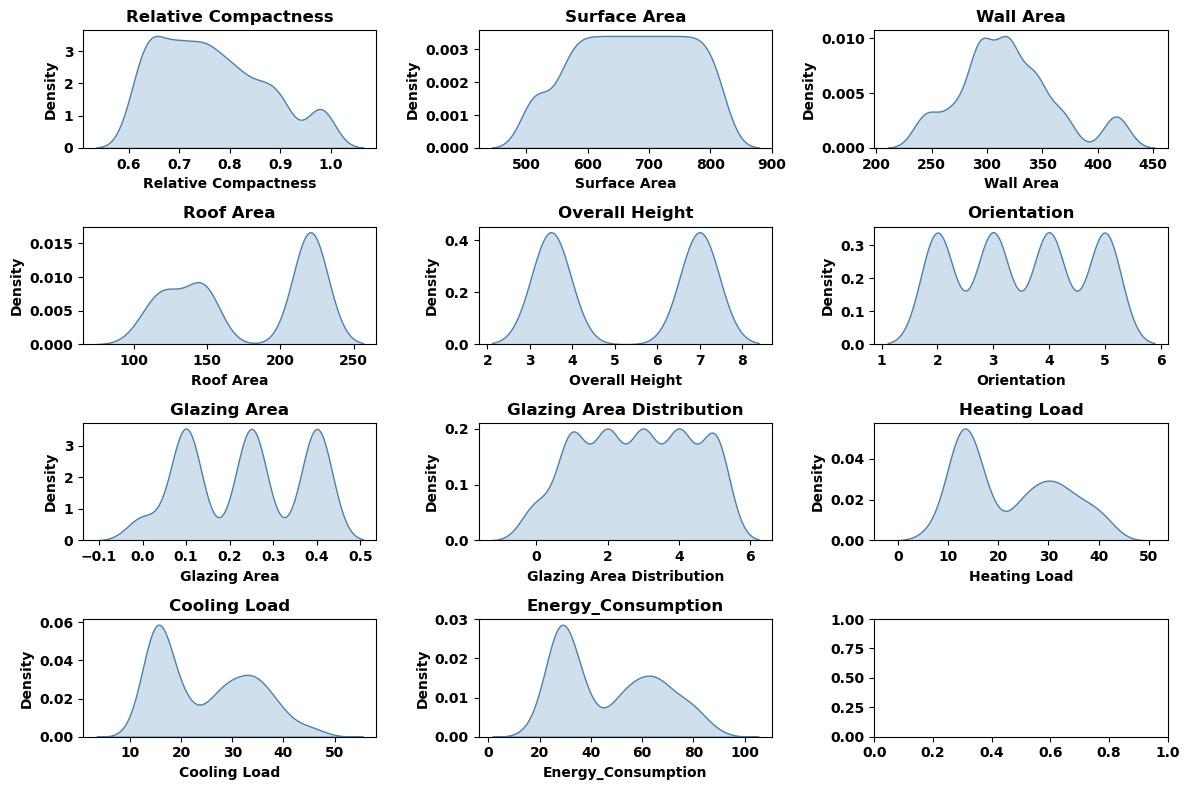

In [8]:
# Create a figure with subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 8))

# Flatten the axes array to simplify plotting
axes = axes.flatten()

# Loop through each feature and create a density plot
for i, feature in enumerate(raw_plot.columns):
    sns.kdeplot(raw_plot[feature], ax=axes[i], color='steelblue', shade=True)
    axes[i].set_title(feature)

# Adjust the layout and spacing of the subplots
fig.tight_layout()

plt.show()

It appears that only surface area follows Gaussian distrbution. The nonlinearity of other featues suggest that this is a complicated dataset.

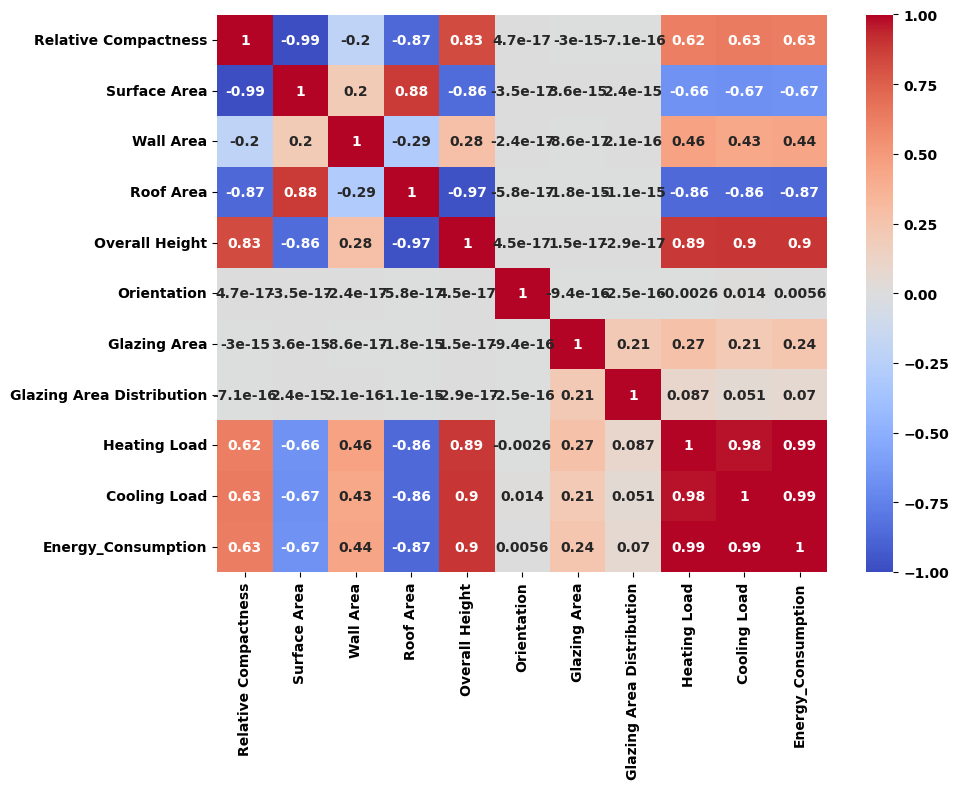

In [9]:
# correlation matrix between all pairs of attributes
corr_matrix = data.corr(method='pearson')

# Create a heatmap using seaborn
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(corr_matrix, vmin=-1, vmax=1, annot=True, cmap="coolwarm", ax=ax)

plt.show()

The correlation matrix indicates heating and coolind loads and energy consumption are strongly correlated to Overall Height and Relative Compactness. 

The Sobol indices are a measure of the importance of each input variable in a simulation model, with respect to its contribution to the output variability. They can be used to determine the most important input variables and to prioritize the areas for improvement in a building design.

In [10]:
# Define the problem for Sobol analysis
problem = {
    'num_vars': 8,
    'names': ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution'],
    'bounds': [(X.iloc[:, i].min(), X.iloc[:, i].max()) for i in range(8)]
}

In [11]:
# Load the fitted Random Forest model from disk
with open('finalized_model.sav', 'rb') as file:
    model_RF = pickle.load(file)

In [12]:
N = 1024 # number of samples
# Generate samples
X_sobol = sobol_sample(problem, N, calc_second_order=False)
# Calculate the Sobol Indices for each target variable
y_sobol = model_RF.predict(X_sobol)
Si = sobol.analyze(problem, y_sobol, calc_second_order=False)

The Sobol indices sensitivity analysis suggest that there is a strong correlation between Energy Consumption and three factors: Glazing Area, Glazing Area Distribution, and Relative Compactness.

Total Sobol Indices for ['Relative_Compactness', 'Surface_Area', 'Wall_Area', 'Roof_Area', 'Overall_Height', 'Orientation', 'Glazing_Area', 'Glazing_Area_Distribution']: 0.9980212012167184


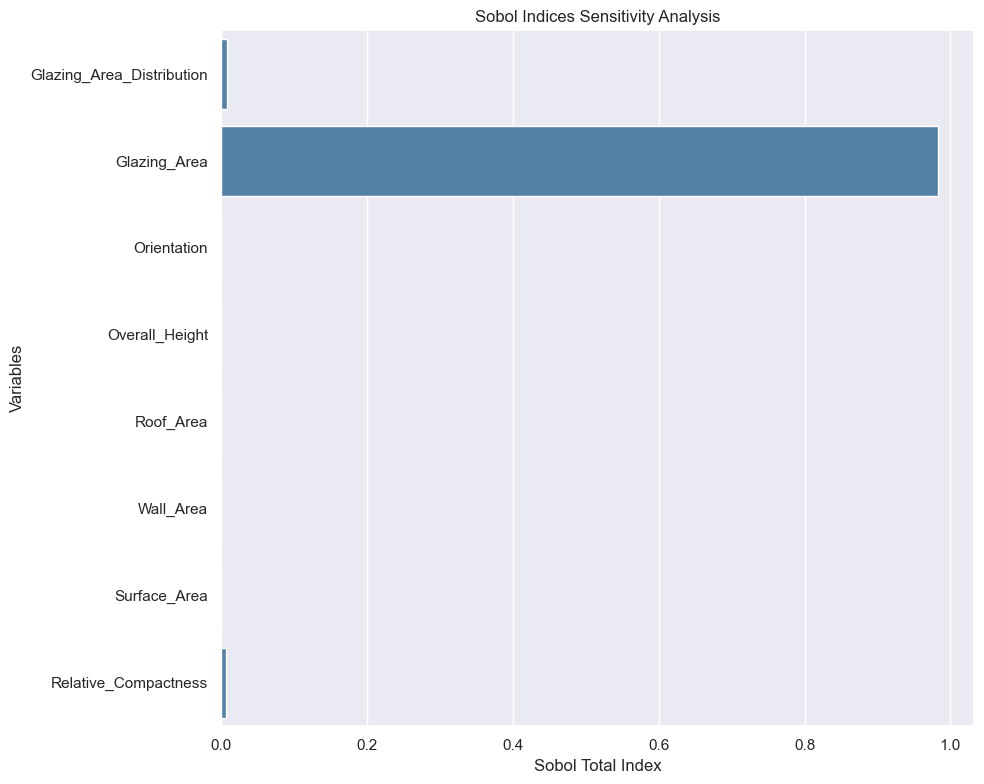

In [13]:
# Set the figure size and style
sns.set(rc={'figure.figsize':(10,8)})

# Get the Sobol indices and variable names
indices = Si['ST']
names = problem['names']

# Create a horizontal bar chart using seaborn
sns.barplot(x=indices, y=names, color='steelblue')

# Set the axis labels and title
plt.xlabel('Sobol Total Index')
plt.ylabel('Variables')
plt.title('Sobol Indices Sensitivity Analysis')

# Invert the y-axis to match the original plot
plt.gca().invert_yaxis()

# Print the total Sobol Indices
print(f"Total Sobol Indices for {list(X.columns)}: {Si['ST'].sum()}")

plt.show()

**3. Prepare Data**

In [14]:
# a) Data Cleaning
# summarize the number of unique values in each column
print(data.nunique())

Relative Compactness          12
Surface Area                  12
Wall Area                      7
Roof Area                      4
Overall Height                 2
Orientation                    4
Glazing Area                   4
Glazing Area Distribution      6
Heating Load                 586
Cooling Load                 636
Energy_Consumption           700
dtype: int64


In [15]:
# Identify columns with missing values and count the number of missing values
data.columns[data.isnull().any()]
print(data.isnull().sum())

Relative Compactness         0
Surface Area                 0
Wall Area                    0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
Cooling Load                 0
Energy_Consumption           0
dtype: int64


It is necessary to eliminate outliers in numerical data columns to improve the accuracy of training and validation processes. This can be done by determining the correlation between these columns and the target variable, identifying columns with low correlation, and then filtering out values that fall outside of the lower and upper bounds.

In [16]:
# calculate the correlation between numerical columns and target variable
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Energy_Consumption']).sort_values(ascending=False)

# filter columns with low correlation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

**4. Optimization process using Pyomo**

Once the Random Forest model was trained, we can use them as the surrogate models in the optimization process using Pyomo package. The process of using a Random Forest model as a surrogate model in the optimization process using Pyomo package involves the following steps:

1. Load the Random Forest model: Load the previously trained Random Forest model using the pickle module in Python.

2. Define the optimization problem: Define the optimization problem in Pyomo. This includes defining the decision variables, objective function, and constraints.

3. Create the Pyomo model instance: Create an instance of the Pyomo model.

4. Define the surrogate model: Define the surrogate model using the pyomo.environ.Param component. The surrogate model takes in the decision variable values and returns the predicted objective function value.

5. Define the Pyomo solver: Define the solver used to solve the optimization problem. Pyomo supports various solvers, such as GLPK, CBC, Gurobi, CPLEX, COUENNE, and IPOPT. Since this is a non-linear optimization problem, I selected IPOPT as the solver.

6. Solve the optimization problem: Use the IPOPT and GUROBI solvers to solve the optimization problem. The solver uses the surrogate model to evaluate the objective function values at each iteration of the optimization algorithm.

7. Evaluate the results: Evaluate the results of the optimization problem, including the optimal decision variable values and the optimal objective function value.


In [17]:
# Create the model
model = ConcreteModel()

# Define variables
m = len(X.columns)
model.x = Var(range(m), within=NonNegativeReals)
x = model.x

In [18]:
# Define constraints
for i in range(m):
    model.x[i].setub(X.iloc[:,i].max())
    model.x[i].setlb(X.iloc[:,i].min())

model.C1 = ConstraintList()
model.C1.add(inequality(X.iloc[:,0].min(), x[0], X.iloc[:,0].max()))
    
model.C2 = ConstraintList()
model.C2.add(inequality(X.iloc[:,1].min(), x[1], X.iloc[:,1].max()))
    
model.C3 = ConstraintList()
model.C3.add(inequality(X.iloc[:,2].min(), x[2], X.iloc[:,2].max()))
    
model.C4 = ConstraintList()
model.C4.add(inequality(X.iloc[:,3].min(), x[3], X.iloc[:,3].max()))
    
model.C5 = ConstraintList()
model.C5.add(inequality(X.iloc[:,4].min(), x[4], X.iloc[:,4].max()))
    
model.C6 = ConstraintList()
model.C6.add(inequality(X.iloc[:,5].min(), x[5], X.iloc[:,5].max()))
    
model.C7 = ConstraintList()
model.C7.add(inequality(X.iloc[:,6].min(), x[6], X.iloc[:,6].max()))
   
model.C8 = ConstraintList()
model.C8.add(inequality(X.iloc[:,7].min(), x[7], X.iloc[:,7].max()))

Check to ensure the constraints were properly set.

In [19]:
print(X.iloc[:,0].max())
print(X.iloc[:,0].min())
print("Lower bound of x[0]:", model.x[0].lb)
print("Upper bound of x[0]:", model.x[0].ub)

0.98
0.62
Lower bound of x[0]: 0.62
Upper bound of x[0]: 0.98


In [20]:
# Define the objective function
def objective_rule(model):
    # Initialize initial value
    model.x[0].set_value(0.7)
    model.x[1].set_value(600)
    model.x[2].set_value(280)
    model.x[3].set_value(150)
    model.x[4].set_value(3.9)
    model.x[5].set_value(3)
    model.x[6].set_value(0.1)
    model.x[7].set_value(2)
    
    # Reshape the inputs for the Random Forest model
    x_reshaped = np.array([value(x[i]) for i in range(m)]).reshape(1, -1)
    # Use the random forest model to predict y
    y_pred = model_RF.predict(x_reshaped)[0]
    # Return the predicted value of y
    return y_pred

model.obj = Objective(rule=objective_rule, sense=minimize)

Pyomo supports a variety of solvers for solving nonlinear optimization problems and among them IPOPT (Interior Point Optimizer) and GUROBI are the popular ones. Please note that GUROBI is a commercial solver. 

IPOPT is an open-source optimization solver developed by Andreas Wächter and Carl Laird that can be used to solve large-scale nonlinear optimization problems with continuous variables, including problems with nonlinear constraints and non-smooth objective functions. 

IPOPT uses an interior point method, which is a type of optimization algorithm that iteratively solves a sequence of barrier subproblems to approach the optimal solution. Specifically, the algorithm solves a sequence of barrier problems, where the barriers are used to "penalize" violations of the constraints and smooth the objective function. By solving this sequence of barrier subproblems, the solver approaches the optimal solution in a way that takes into account the constraints of the problem.

In [21]:
# Solve the problem using IPOPT solver
solver = SolverFactory('ipopt', executable='D:/PROJECTS/Data analytics/Solvers/bin/ipopt.exe')
results = solver.solve(model, tee=True)

print(value(model.obj))

Ipopt 3.12.4: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.4, running with linear solver pardiso.

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        8
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        8
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        8
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of i

In [22]:
# Print the last value of X or optimum set of parameters that yield minimum energy consumption
x_value = []
for i in model.x:
    x_value.append(value(model.x[i]))

print("Optimum building design parameters value using IPOPT solver:")
for col_name, col_value in zip(X.columns, x_value):
    print(f"- {col_name}: {col_value}")

Optimum building design parameters value using IPOPT solver:
- Relative_Compactness: 0.7997013010459073
- Surface_Area: 609.5197496629124
- Wall_Area: 289.8655170368338
- Roof_Area: 153.7186630718118
- Overall_Height: 5.095951600600986
- Orientation: 3.451090469149368
- Glazing_Area: 0.19958073084996458
- Glazing_Area_Distribution: 2.4203314079227023


Gurobi is an LP solver that performs model preprocessing, initializes the simplex tableau, uses the simplex method to find a feasible and/or optimal solution, maintains a basis throughout the algorithm, and switches to the dual simplex or interior point method as necessary. Gurobi also uses solution refinement techniques and returns the optimal solution, solution status, and other information to the calling program.

In [23]:
# Solve the problem using GUROBI solver with nonconvex option 
solver = SolverFactory('gurobi', executable='D:/PROJECTS/Data analytics/Solvers/bin/gurobi/bin/gurobi.bat')
solver.options['NonConvex'] = 2
results = solver.solve(model, tee=True)

print(value(model.obj))

    solver failure.
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-01
Read LP format model from file C:\Users\huyha\AppData\Local\Temp\tmpgp39itcj.pyomo.lp
Reading time = 0.00 seconds
x9: 17 rows, 9 columns, 17 nonzeros
Set parameter NonConvex to value 2
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (win64)

CPU model: Intel(R) Core(TM) i5-1035G4 CPU @ 1.10GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 17 rows, 9 columns and 17 nonzeros
Model fingerprint: 0x6fc1d20e
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [5e+01, 5e+01]
  Bounds range     [4e-01, 8e+02]
  RHS range        [4e-01, 8e+02]
Presolve removed 17 rows and 9 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    4.5968000e+01   0.000000e+00   0.000000e+00      0s

S

In [24]:
# Print the last value of X or optimum set of parameters that yield minimum energy consumption
x_value = []
for i in model.x:
    x_value.append(value(model.x[i]))

print("Optimum building design parameters value using GUROBI solver:")
for col_name, col_value in zip(X.columns, x_value):
    print(f"- {col_name}: {col_value}")

Optimum building design parameters value using GUROBI solver:
- Relative_Compactness: 0.62
- Surface_Area: 514.5
- Wall_Area: 245.0
- Roof_Area: 110.25
- Overall_Height: 3.5
- Orientation: 2.0
- Glazing_Area: 0.0
- Glazing_Area_Distribution: 0.0


Comparing the results obtained from the Pyomo package with those obtained from Bayesian inference, it appears that the Pyomo package provides a more optimal solution. There are some general factors that could contribute to the differences in performance between the two methods.

Firstly, Pyomo with IPOPT and GUROBI solvers is a deterministic optimization approach, which means that it tries to find the best solution for a given set of constraints and objective function. In contrast, Bayesian inference is a probabilistic approach that relies on assumptions about the distribution of the parameters and uncertainty in the model.

Secondly, Pyomo with Gurobi solver is recommended over the IPOPT which designed to solve non-linear optimization problems, because the global minimum is always guaranteed. Non-linear optimization problems can have complex and non-convex objective functions, which makes it challenging to find the global minimum.

**5. Conclusions**

- The results of the Sobol indices sensitivity analysis indicate that Energy Consumption is strongly correlated with three factors: Glazing Area, Glazing Area Distribution, and Relative Compactness. These factors have the highest Sobol indices, indicating that they have the greatest impact on the Energy Consumption.

- Using the IPOPT and GUROBI solvers, a specialized solver for nonlinear optimization, the optimization process was able to converge to a minimum Energy Consumption of 45.968 kWh after approximately 6 iterations for IPOPT and 1 iteration for GUROBI. This suggests that the chosen optimization solvers were effective in finding the optimal solution for the problem.

- Comparing the results obtained from the Pyomo package with those obtained from Bayesian inference, it appears that the Pyomo package provides a more optimal solution, with an Energy Consumption value of 45.968 kWh compared to the Bayesian inference value of 52.027 kWh.

- Pyomo with IPOPT and GUROBI solvers may have achieved a better optimal value due to its deterministic nature (Bayesian inference is a probabilistic approach), ability to solve non-linear problems, and specific implementation details. And between these two solvers, GUROBI is highly recommended due to its rubustness in finding global optimum just with 1 iteration and also the global minimum is guaranteed.